SSAM example: osmFISH mouse somatosensory cortex data
=================================================

Here we analyze the mouse somatosensory cortex data, which is measured by osmFISH (*Nature Methods*, **15**, 932–935, 2018).

The data used here is available at: http://linnarssonlab.org/osmFISH/availability/

## 0. Prerequisites



In [1]:
# install required python modules
!pip install loom
!pip install git+https://github.com/eilslabs/ssam
    
# Download raw data (mRNA coordinates)
!wget --quiet https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/osmFISH/data/mRNA_coords_raw_counting.hdf5

## 1. Define parameters

In [2]:
filename = "mRNA_coords_raw_counting.hdf5"
bandwidth = 2 # um
sampling_distance = 1 # um
pixel_per_um = 15.3846 # from BioRxiv paper
width, height = 2080, 3380 # um
ncores = 10 # Number of cores used for kernel density estimation

## Parameters for post-filtering of cell type maps
filter_method = "local"
filter_params = {
    "block_size": 151,
    "method": "mean",
    "mode": "constant",
    "offset": -0.5
}

## 2. Load mRNA location data

In [3]:
import numpy as np
import h5py
from collections import OrderedDict

um_per_pixel = 1.0 / pixel_per_um
f = h5py.File(filename, 'r')
keys = list(f.keys())

pos_dic = OrderedDict()
genes = []

# Exclude bad quality data, according to the supplementary material of osmFISH paper
blacklists = ['Cnr1_Hybridization4', 'Plp1_Hybridization4', 'Vtn_Hybridization4',
              'Klk6_Hybridization5', 'Lum_Hybridization9', 'Tbr1_Hybridization11']

for k in keys:
    if k in blacklists:
        continue
    gene = k.split("_")[0]
    
    # Correct wrong gene labels
    if gene == 'Tmem6':
        gene = 'Tmem2'
    elif gene == 'Kcnip':
        gene = 'Kcnip2'
    
    points = np.array(f[k]) * um_per_pixel
    if gene in pos_dic:
        pos_dic[gene] = np.vstack((pos_dic[gene], points))
    else:
        pos_dic[gene] = points
        genes.append(gene)
genes = sorted(genes)

## 3. Run SSAM

In [4]:
import ssam
import matplotlib.pyplot as plt

all_genes = list(pos_dic.keys())
mrna_loci = [pos_dic[gene] for gene in all_genes]

ds = ssam.SSAMDataset(all_genes, mrna_loci, width, height)
analysis = ssam.SSAMAnalysis(ds, ncores=ncores, save_dir="data", verbose=True)

analysis.run_kde(bandwidth=bandwidth, use_mmap=False)

In [5]:
# Cut off the excluded region from the image
width_cutoff = 1640 # um
ds.vf = ds.vf[:width_cutoff, ...]

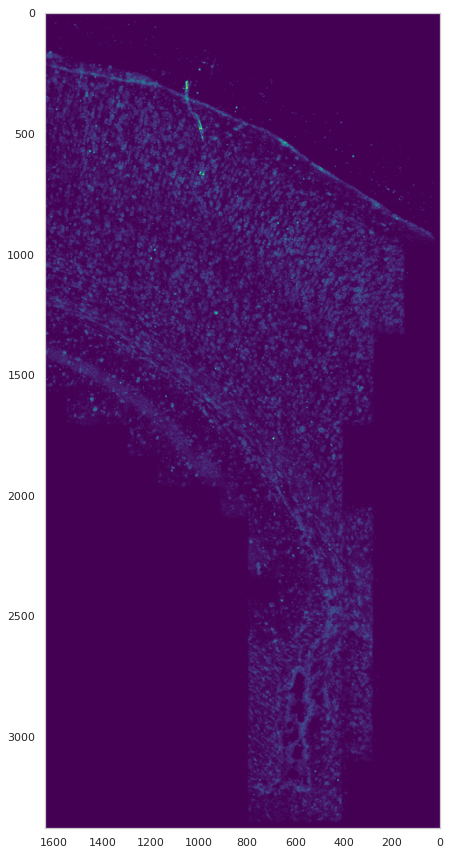

In [6]:
plt.figure(figsize=[10, 15])
ds.plot_l1norm(cmap='viridis', rotate=1)
plt.show()

### 3-1. SSAM semi-supervised mode: map osmFISH cluster centroids to the vector field

In [7]:
# Download raw data (quantified mRNA data based on segmentation)
!wget --quiet http://linnarssonlab.org/osmFISH/osmFISH_SScortex_mouse_all_cells.loom

In [8]:
# Load osmFISH data
import loompy
osm_loom = loompy.connect("osmFISH_SScortex_mouse_all_cells.loom")

In [9]:
from sklearn.preprocessing import normalize

osm_genes = list(osm_loom.row_attrs['Gene'])
osm_clusters = osm_loom.col_attrs['ClusterName']
osm_uniq_clusters = sorted(set(osm_clusters) - set(['Excluded']))

osm_gene_indices = [osm_genes.index(gene) for gene in ds.genes]
osm_data = osm_loom[:,:].T[:, osm_gene_indices]
osm_data = normalize(osm_data, norm='l1', axis=0) * osm_data.shape[1] # Normalize per gene
osm_data = normalize(osm_data, norm='l1', axis=1) * osm_data.shape[0] # Normalize per cell

In [10]:
osmfish_centroids = np.zeros([len(osm_uniq_clusters), len(osm_genes)])
for cl_idx, osm_cluster in enumerate(osm_uniq_clusters):
    osmfish_centroids[cl_idx, :] = np.mean(osm_data[osm_clusters == osm_cluster, :], axis=0)

In [11]:
analysis.map_celltypes(osmfish_centroids, min_norm=filter_method, filter_params=filter_params)

In [12]:
osm_clustercolors = {
    "Inhibitory CP": "#9b067d",
    "Inhibitory Crhbp": "#9805cc",
    "Inhibitory Cnr1": "#ca4479",
    "Inhibitory IC": "#ff49b0",
    "Inhibitory Kcnip2": "#af7efe",
    "Inhibitory Pthlh": "#4e14a6",
    "Inhibitory Vip": "#7759a4",
    "Pyramidal Cpne5": "#3e4198",
    "Pyramidal L2-3": "#0ab4e4",
    "Pyramidal L2-3 L5": "#1e6a87",
    "Pyramidal Kcnip2": "#6787d6",
    "Pyramidal L3-4": "#004dba",
    "pyramidal L4": "#78edff",
    "Pyramidal L5": "#0a9fb4",
    "Pyramidal L6": "#027fd0",
    "Hippocampus": "#004b71",
    "Astrocyte Gfap": "#de4726",
    "Astrocyte Mfge8": "#f69149",
    "Oligodendrocyte Precursor cells": "#b3ee3d",
    "Oligodendrocyte COP": "#5dd73d",
    "Oligodendrocyte NF": "#64a44e",
    "Oligodendrocyte MF": "#2f7449",
    "Oligodendrocyte Mature": "#285528",
    "Perivascular Macrophages": "#762a14",
    "Microglia": "#a7623d",
    "C. Plexus": "#21b183",
    "Ependymal": "#fadf0b",
    "Pericytes": "#f8c495",
    "Endothelial": "#f81919",
    "Endothelial 1": "#f05556",
    "Vascular Smooth Muscle": "#aec470",
}
celltype_colors = [osm_clustercolors[cl] for cl in osm_uniq_clusters]

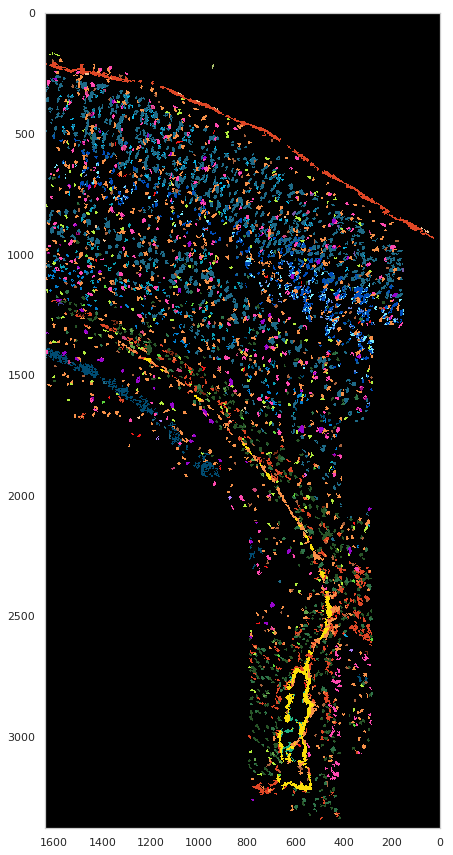

In [13]:
plt.figure(figsize=[10, 15])
ds.plot_celltypes_map(colors=celltype_colors, rotate=1)
plt.show()

Apply output mask based on PolyA segmentation

In [14]:
# Download segmentation data
!wget --quiet https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/osmFISH/data/polyT_seg.pkl

In [15]:
import pickle
with open("polyT_seg.pkl", "rb") as f:
    seg_dic = pickle.load(f)

In [16]:
seg_mask = np.zeros([width, height])
for seg_coords in seg_dic.values():
    seg_coords_small = (seg_coords / pixel_per_um).astype(int)
    seg_mask[seg_coords_small[:, 0], seg_coords_small[:, 1]] = 1
seg_mask = seg_mask[:width_cutoff, :]

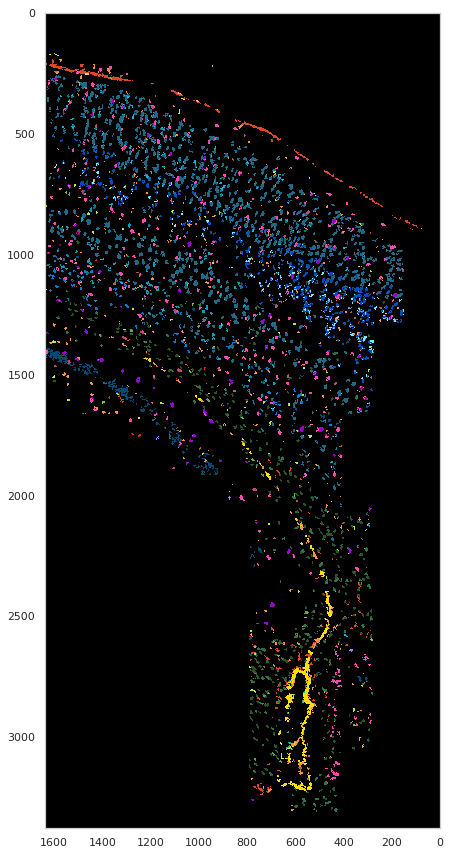

In [17]:
plt.figure(figsize=[10, 15])
ds.plot_celltypes_map(output_mask=seg_mask.T, min_norm=0, colors=celltype_colors, rotate=1)
plt.show()

### 3-2. SSAM unsupervised mode: *de novo* clustering of vectors

In [18]:
analysis.find_localmax(search_size=10, min_norm=0.1)

Found 9649 local max vectors.


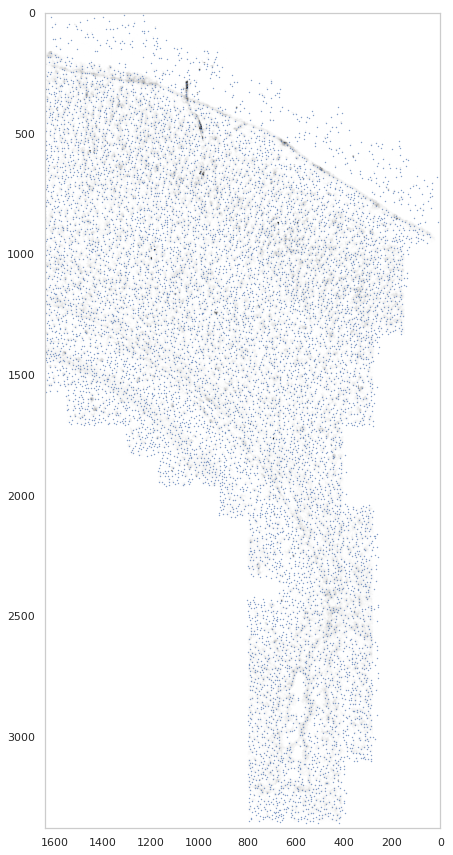

In [19]:
plt.figure(figsize=[10, 15])
ds.plot_l1norm(cmap="Greys", rotate=1)
ds.plot_localmax(c="blue", rotate=1, s=0.1)
plt.show()

In [20]:
analysis.normalize_vectors(norm="l1", normalize_gene=True, normalize_vector=True)

In [21]:
analysis.cluster_vectors(min_cluster_size=0, pca_dims=33, resolution=0.6, metric='correlation')

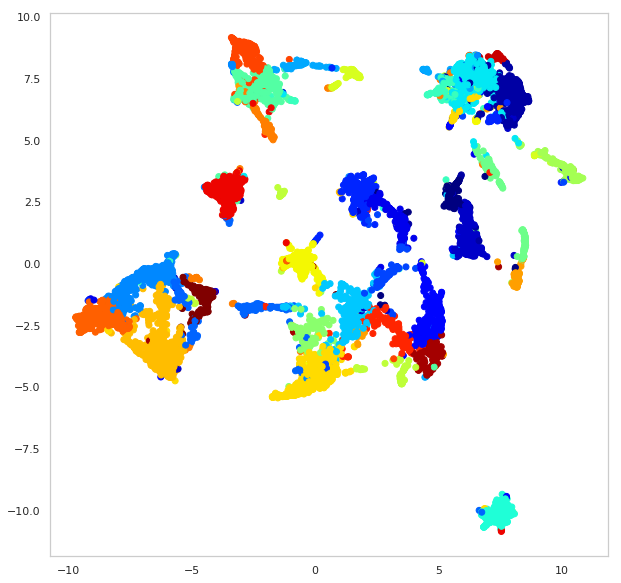

In [22]:
plt.figure(figsize=[10, 10])
ds.plot_umap(pca_dims=33, metric="correlation")
plt.show()

In [23]:
analysis.map_celltypes(min_r=0.6, min_norm="local", filter_params={
    "block_size": 151,
    "method": "mean",
    "mode": "constant",
    "offset": -0.5
})

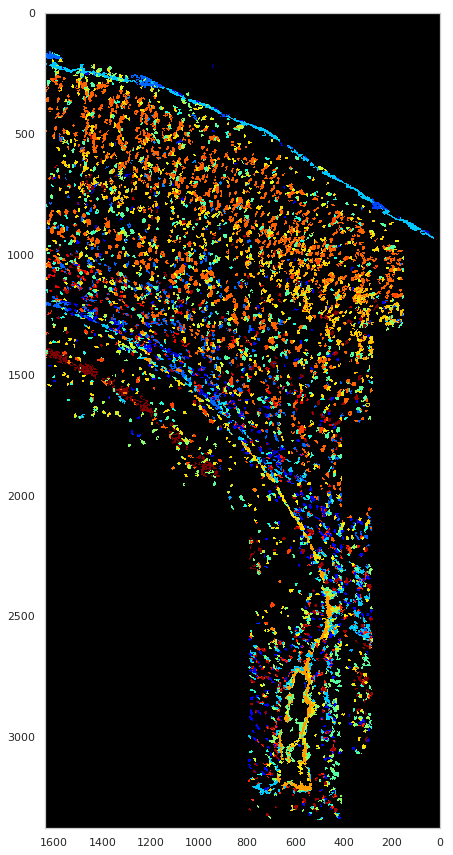

In [24]:
plt.figure(figsize=[10, 15])
ds.plot_celltypes_map(rotate=1)
plt.show()

In [25]:
# Match colors to make it comparable with the original data!
osm_corrs = np.zeros((len(ds.centroids), len(osmfish_centroids)))
for i, centroid in enumerate(ds.centroids):
    for j, osmfish_centroid in enumerate(osmfish_centroids):
        osm_corrs[i, j] = ssam.utils.corr(centroid, osmfish_centroid)

osm_corrs[osm_corrs < 0] = 0
osm_max_corr_idx = np.argmax(osm_corrs, axis=1)
osm_rowheaders = np.array(osm_uniq_clusters)[osm_max_corr_idx]
# print(len(set(osm_rowheaders)))
# print('\n'.join(sorted(set(osm_rowheaders))))

In [26]:
# Beware that this can make some clusters have the same color!
denovo_celltype_colors = []
for cl, r in zip(osm_rowheaders, np.max(osm_corrs, axis=1)):
    denovo_celltype_colors.append(osm_clustercolors[cl])

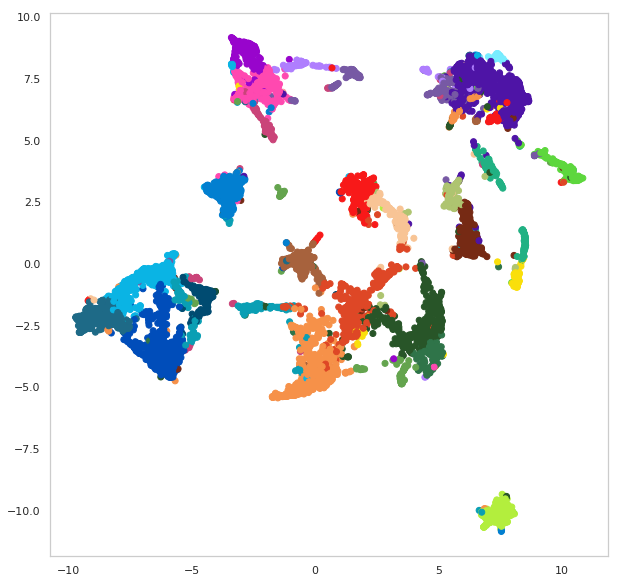

In [27]:
plt.figure(figsize=[10, 10])
ds.plot_umap(colors=denovo_celltype_colors)
plt.show()

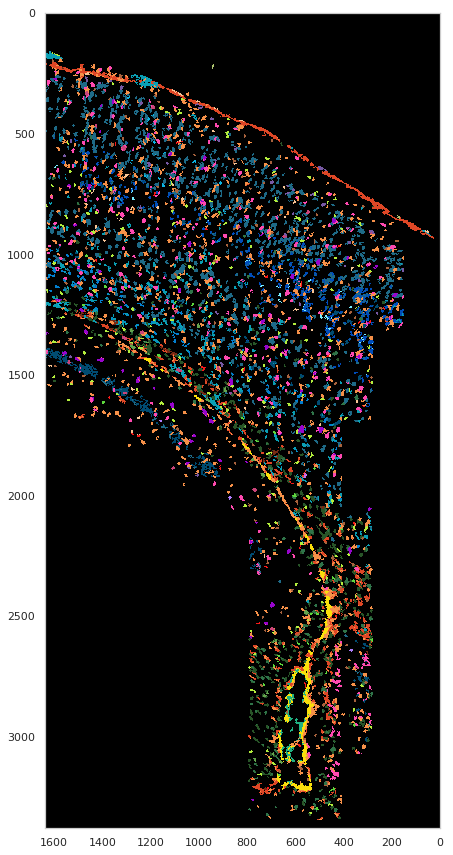

In [28]:
plt.figure(figsize=[10, 15])
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1)
plt.show()

Apply output mask based on PolyA segmentation

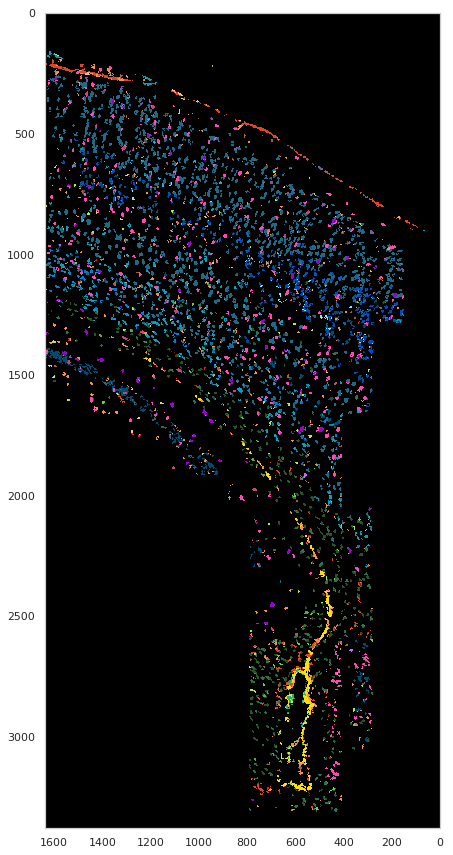

In [29]:
plt.figure(figsize=[10, 15])
ds.plot_celltypes_map(output_mask=seg_mask.T, min_norm=0, colors=denovo_celltype_colors, rotate=1)
plt.show()